In [60]:
import sys
import os
import numpy as np
from pathlib import Path
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
from PyQt6.QtWidgets import QApplication, QWidget, QVBoxLayout, QLabel, QSlider, QCheckBox, QHBoxLayout
from PyQt6.QtCore import Qt, QTimer
import pyqtgraph as pg
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

In [ ]:
# Load data
current_file_path = os.getcwd()
data_path = os.path.join(current_file_path, 'data', 'sample-laser-radar-measurement-data-1_copy.txt')
# data_path = os.path.join(current_file_path, 'data', 'sample-laser-radar-measurement-data-2.txt')

def load_data(filepath):
    radar_data = []
    lidar_data = []
    with open(filepath, 'r') as file:
        last = None
        for line in file:
            line = line.strip().split('\t')
            # R ρ φ ρ̇ timestamp x_gt y_gt vx_gt vy_gt
            # R 8.46642 0.0287602 -3.04035 1477010443399637 8.6 0.25 -3.00029 0
            if line[0] == 'R':
                range_, angle, angle_rate, time, x_gt, y_gt, vx_gt, vy_gt = map(float, line[1:])
                x = range_ * np.cos(angle)
                y = range_ * np.sin(angle)
                vx = angle_rate * np.cos(angle)
                vy = angle_rate * np.sin(angle)
                radar_data.append((line[0], time, np.array([x, vx, y, vy]).reshape(4,1), x_gt, y_gt, vx_gt, vy_gt))
            # L x y timestamp x_gt y_gt vx_gt vy_gt
            elif line[0] == 'L':
                x, y, time, x_gt, y_gt, vx_gt, vy_gt = map(float, line[1:])
                if last == None:
                    lidar_data.append((line[0], time, np.array([x, 0, y, 0]).reshape(4,1), x_gt, y_gt, vx_gt, vy_gt))
                    last = x, y, time
                else:
                    vx = (x - last[0])/(time - last[2])*1e6
                    vy = (y - last[1])/(time - last[2])*1e6
                    last = x, y, time
                    lidar_data.append((line[0], time, np.array([x, vx, y, vy]).reshape(4,1), x_gt, y_gt, vx_gt, vy_gt))

    return radar_data, lidar_data

radar_data, lidar_data = load_data(data_path)


In [62]:
class KalmanApp(QWidget):
    def __init__(self):
        super().__init__()
        self.setWindowTitle('Real-Time Kalman Filter Tuning')
        self.resize(800, 600)

        layout = QVBoxLayout()

        # Plot widget
        self.plot = pg.PlotWidget()
        self.plot.setXRange(-10, 10)
        self.plot.setYRange(-10, 10)
        self.plot.addLegend()
        layout.addWidget(self.plot)

        # Timer for delayed updates
        self.update_timer = QTimer()
        self.update_timer.setInterval(100)
        self.update_timer.setSingleShot(True)
        self.update_timer.timeout.connect(self.update_kalman)
        self.var_scale = int(1e8)
        # Sliders and labels
        self.q_slider, self.q_label = self.create_slider('Process Noise (Q)', layout, 1, int(0.25*self.var_scale), default_value=int(0.000001*self.var_scale))
        self.radar_slider, self.radar_label = self.create_slider('Radar Noise (R)', layout, 1, 1*self.var_scale, default_value=int(0.003294*self.var_scale))
        self.lidar_slider, self.lidar_label = self.create_slider('Lidar Noise (R)', layout, 1, 1*self.var_scale, default_value=int(0.001891*self.var_scale))

        # Checkboxes
        self.radar_checkbox = QCheckBox('Use Radar')
        self.radar_checkbox.setChecked(True)
        self.radar_checkbox.stateChanged.connect(self.update_kalman)
        layout.addWidget(self.radar_checkbox)

        self.lidar_checkbox = QCheckBox('Use Lidar')
        self.lidar_checkbox.setChecked(True)
        self.lidar_checkbox.stateChanged.connect(self.update_kalman)
        layout.addWidget(self.lidar_checkbox)

        self.setLayout(layout)

        # Data curves
        self.radar_curve = self.plot.plot([], [], pen='r', name='Radar')
        self.lidar_curve = self.plot.plot([], [], pen='g', name='Lidar')
        self.kf_curve = self.plot.plot([], [], pen='b', name='KF')
        
        self.fig, self.axs = plt.subplots(3, 2, figsize=(12, 8))  # Create a 3x2 grid of subplots

        self.update_kalman()

    def create_slider(self, name, parent_layout, min_val, max_val, default_value):
        container = QHBoxLayout()
        slider = QSlider(Qt.Orientation.Horizontal)
        slider.setMinimum(min_val)
        slider.setMaximum(max_val)
        slider.setValue(default_value)  # Midpoint

        label = QLabel(f"{name}: {slider.value()/self.var_scale:.8f}")  # MATCH slider value
        container.addWidget(label)
        container.addWidget(slider)
        parent_layout.addLayout(container)

        def on_slider_change(value, lbl=label, nm=name):
            lbl.setText(f"{nm}: {value/self.var_scale:.8f}")
            self.schedule_update_kalman()

        slider.valueChanged.connect(on_slider_change)
        return slider, label

    def schedule_update_kalman(self):
        self.update_timer.start()

    def plot_time_series_results(self):
        kf_output = self.kf_output
        time_data = self.time_data
        # x_gt, y_gt, vx_gt, vy_gt
        ground_truth = np.array([[gt[3], gt[4], gt[5], gt[6]] for gt in time_data])
        time_series = (np.array([stored_data[1] for stored_data in time_data]) - time_data[0][1])/1e6

        for ax in self.axs.flatten():
            ax.clear()

        # Plot each state variable
        self.axs[0, 0].plot(time_series, kf_output[1:, 0], label='KF Estimate')
        self.axs[0, 0].plot(time_series, ground_truth[:, 0], label='Ground Truth', linestyle='--')
        self.axs[0, 0].set_title('Comparison of x')
        self.axs[0, 0].set_xlabel('Time Step')
        self.axs[0, 0].set_ylabel('x')
        self.axs[0, 0].legend()

        self.axs[1, 0].plot(time_series, kf_output[1:, 1], label='KF Estimate')
        self.axs[1, 0].plot(time_series, ground_truth[:, 2], label='Ground Truth', linestyle='--')
        self.axs[1, 0].set_title('Comparison of ẋ')
        self.axs[1, 0].set_xlabel('Time Step')
        self.axs[1, 0].set_ylabel('ẋ')
        self.axs[1, 0].legend()

        self.axs[2, 0].plot(time_series, kf_output[1:, 2], label='KF Estimate')
        self.axs[2, 0].set_title('Comparison of ẍ')
        self.axs[2, 0].set_xlabel('Time Step')
        self.axs[2, 0].set_ylabel('ẍ')
        self.axs[2, 0].legend()

        self.axs[0, 1].plot(time_series, kf_output[1:, 3], label='KF Estimate')
        self.axs[0, 1].plot(time_series, ground_truth[:, 1], label='Ground Truth', linestyle='--')
        self.axs[0, 1].set_title('Comparison of y')
        self.axs[0, 1].set_xlabel('Time Step')
        self.axs[0, 1].set_ylabel('y')
        self.axs[0, 1].legend()

        self.axs[1, 1].plot(time_series, kf_output[1:, 4], label='KF Estimate')
        self.axs[1, 1].plot(time_series, ground_truth[:, 3], label='Ground Truth', linestyle='--')
        self.axs[1, 1].set_title('Comparison of ẏ')
        self.axs[1, 1].set_xlabel('Time Step')
        self.axs[1, 1].set_ylabel('ẏ')
        self.axs[1, 1].legend()

        self.axs[2, 1].plot(time_series, kf_output[1:, 5], label='KF Estimate')
        self.axs[2, 1].set_title('Comparison of ÿ')
        self.axs[2, 1].set_xlabel('Time Step')
        self.axs[2, 1].set_ylabel('ÿ')
        self.axs[2, 1].legend()

        # Adjust layout for better spacing between plots
        self.fig.tight_layout()

        # Refresh the figure
        # Clear the output from the previous plot
        clear_output(wait=True)

        # Display the new plot
        display(self.fig)
    
    def update_kalman(self):
        var_process = self.q_slider.value() / self.var_scale
        var_radar = self.radar_slider.value() / self.var_scale
        var_lidar = self.lidar_slider.value() / self.var_scale
        use_radar = self.radar_checkbox.isChecked()
        use_lidar = self.lidar_checkbox.isChecked()

        dt = 1
        kf = KalmanFilter(dim_x=6, dim_z=4)
        block_F = np.array([[1, dt, 0.5*dt**2], [0, 1, dt], [0, 0, 1]])
        kf.F[0:3, 0:3] = block_F
        kf.F[3:6, 3:6] = block_F
        block_H = np.array([[1,0,0],[0,1,0]])
        kf.H[0:2,0:3] = block_H
        kf.H[2:4,3:6] = block_H
        kf.P *= 10
        kf.Q = Q_discrete_white_noise(dim=3, dt=dt, var=var_process, block_size=2)
        kf.x = np.array([[8],[0],[0],[0],[0],[0]])

        x_kf, y_kf = [kf.x[0,0]], [kf.x[3,0]]
        self.time_data = sorted(radar_data + lidar_data, key=lambda x: x[1])
        self.kf_output = np.empty((len(self.time_data) + 1, 6)) #To insert the initialization point too
        self.kf_output[0] = np.array([[8],[0],[0],[0],[0],[0]]).T
        last_t = self.time_data[0][1]

        for i, (sensor, time, z, *_) in enumerate(self.time_data):
            dt = (time - last_t)/1e6
            if dt > 0:
                last_t = time
                kf.F[0:3, 0:3] = np.array([[1, dt, 0.5*dt**2], [0, 1, dt], [0, 0, 1]])
                kf.F[3:6, 3:6] = np.array([[1, dt, 0.5*dt**2], [0, 1, dt], [0, 0, 1]])
                kf.Q = Q_discrete_white_noise(dim=3, dt=dt, var=var_process, block_size=2)

            if sensor == 'L':
                if not use_lidar:
                    continue
                kf.R = np.eye(4) * var_lidar
            else:
                if not use_radar:
                    continue
                kf.R = np.eye(4) * var_radar

            kf.predict()
            kf.update(z)
            self.kf_output[i+1] = kf.x.T
            x_kf.append(kf.x[0,0])
            y_kf.append(kf.x[3,0])

        if use_radar:
            radar_pts = [(z[0,0], z[2,0]) for _,_,z,*_ in radar_data]
            self.radar_curve.setData(*zip(*radar_pts))
        else:
            self.radar_curve.setData([], [])

        if use_lidar:
            lidar_pts = [(z[0,0], z[2,0]) for _,_,z,*_ in lidar_data]
            self.lidar_curve.setData(*zip(*lidar_pts))
        else:
            self.lidar_curve.setData([], [])
        self.kf_curve.setData(x_kf, y_kf)
        self.plot.enableAutoRange()

        #Plot the timeseries results
        self.plot_time_series_results()




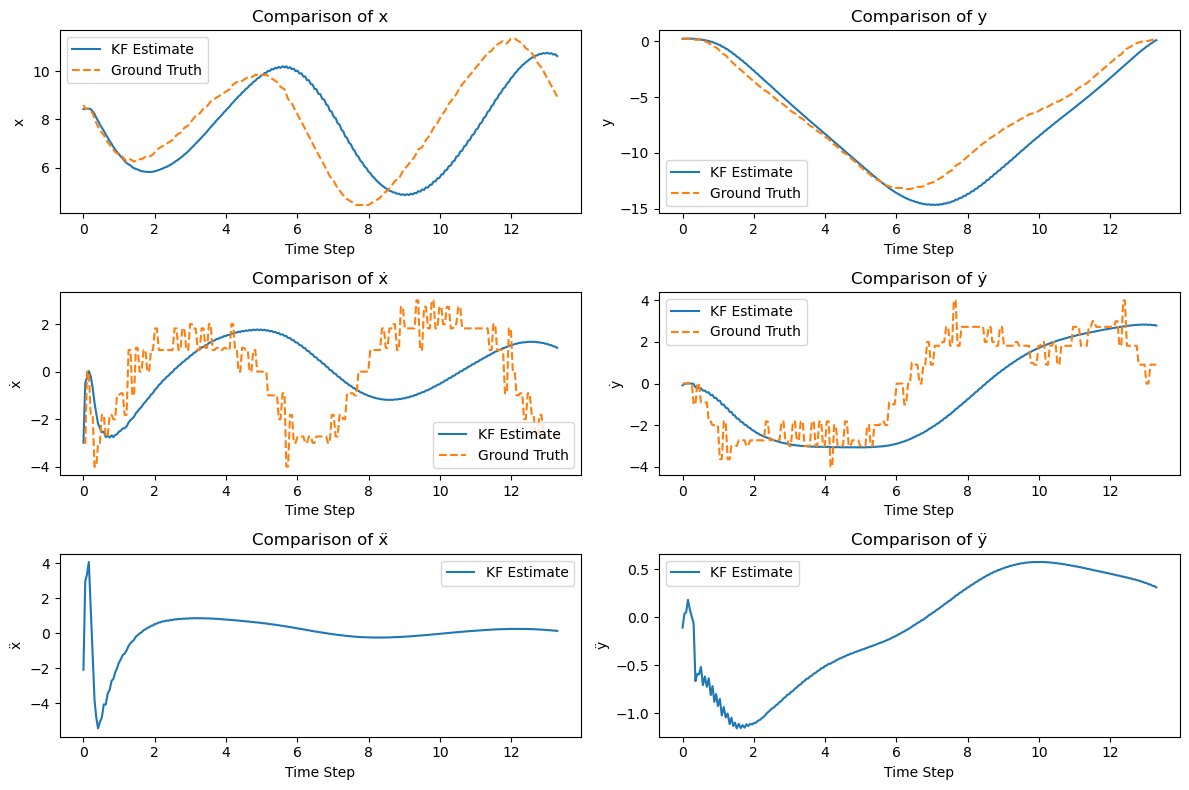

In [ ]:

%gui qt  

app = QApplication.instance()
if app is None:
    app = QApplication([])

win = KalmanApp()
win.show()